<a href="https://colab.research.google.com/github/jermwatt/ocr_preprocessing/blob/main/ocr_preprocessing_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import os
# if running in collab pull repo and install requirements
if os.getenv("COLAB_RELEASE_TAG"):
    !git clone https://github.com/jermwatt/ocr_preprocessing.git
    %cd ocr_preprocessing
    !pip install -r requirements.txt
    !sudo apt install tesseract-ocr
    !apt-get install tesseract-ocr-vie -y

Cloning into 'ocr_preprocessing'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 59 (delta 29), reused 35 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 1.62 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/ocr_preprocessing/ocr_preprocessing/ocr_preprocessing
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-vie is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


# Pre-processing steps for ocr

- ocr is a classic example of an "ai pipeline" that is not just a single ai model (ocr)
- this is true whether you use a "classic" ocr model - that is, one made explicitly to detect text-symbols - or a "transformer" model - a vllm finetuned for ocr like tasks - pre and post processing are almost always necessary
- in this notebook, we describe several standard preprocessing steps for ocr
- stick around here to see how all this stuff works, or fire up the streamlit app (see this repo's `README.md`) locally to start playing around immediately

---

- significant pre and post processing steps are almost always necessary to achieve even decent results, and all of these steps together are a true "ocr pipeline"
- post-processing involves taking the output of ocr is almost universally performed when using detection-based ocr models like the popular [tesseract](https://github.com/tesseract-ocr/tesseract)
- we will discuss these in a future notebook
- our discussion will center on steps towards preparing the image below as best as possilbe for ocr
- looks like a black rectangle doesn't it?  there's actually something there - we'll see by applying preprocessing

<img src="https://github.com/jermwatt/ocr_preprocessing/blob/main/data/input/seal_rotated.png?raw=1" width="50%">

## Pre-processing steps

- pre-processing is extremely helpful, almost a necessity, for most ocr pipeline applications
- here we illustrate the following common steps in python
    1.  pixel intensity normalization: standard image normalization step: ensure all values in input image lie in proper range ([0,255])
    2.  image denoising: cleans up image
    3.  grayscale: convert image to grayscale
    4.  deskewing: ensure image is properly rotated linearly
    5.  binarization: convert grayscale image to binary

- generally speaking most of these steps are sensible to apply to data before processing with any AI model - e.g., normalization is good practice for any process used frequently
- the final binarization severely changes the input image, but is helpful since our goal is just to extract its text
- the code for these steps is below, along with a helper function to illustrate each step
- [opencv](https://github.com/opencv/opencv-python) is a common tool for many processing steps like those below
- we also use the helpful [deskew](https://github.com/sbrunner/deskew) library
- we run the code and discuss afterwards

In [64]:
import cv2
import math
import numpy as np
from PIL import Image
from typing import Tuple
import matplotlib.pyplot as plt
from deskew import determine_skew


def deskew_image(image: np.ndarray) -> np.ndarray:
    angle = determine_skew(image)
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=(0, 0, 0))


def preprocess_image(img_path: str, threshold_val: int = 235) -> Tuple:
    img_orig = Image.open(img_path)
    img_orig=np.array(img_orig)
    img_orig=cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR)

    # normalize
    img_norm = cv2.normalize(img_orig, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # denoise
    img_denoise = cv2.bilateralFilter(img_norm,5, 55,60)

    # grayscale
    img_gray = cv2.cvtColor(img_denoise, cv2.COLOR_BGR2GRAY)

    # skew correction
    img_deskew = deskew_image(img_gray)

    # threshold
    _, img_thresh = cv2.threshold(img_deskew, threshold_val, 255, 1)


    return img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh


def plot_processing_images(img_orig: np.ndarray,
                           img_norm: np.ndarray,
                           img_denoise: np.ndarray,
                           img_gray: np.ndarray,
                           img_deskew: np.ndarray,
                           img_thresh: np.ndarray) -> None:
    # Ensure threshold image is uint8 single channel
    if img_thresh.dtype != np.uint8:
        img_thresh = (img_thresh * 255).astype(np.uint8)

    # Resize threshold mask to match original if needed
    if img_thresh.shape[:2] != img_orig.shape[:2]:
        img_thresh = cv2.resize(img_thresh, (img_orig.shape[1], img_orig.shape[0]))

    # Invert mask — because we want text (black in thresh) to stay colored
    mask_inv = cv2.bitwise_not(img_thresh)

    # Create white background
    white_bg = np.ones_like(img_orig, dtype=np.uint8) * 255

    # Apply inverted mask: keep original where text (dark), else white
    if img_orig.ndim == 3:
        img_masked = np.where(mask_inv[..., None] > 0, img_orig, white_bg)
    else:
        img_masked = np.where(mask_inv > 0, img_orig, white_bg)

    # --- Plot all images (4x2 = 8 slots total) ---
    fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(8, 10))
    axarr = axarr.flatten()
    fig.tight_layout(pad=2.0)

    # --- Define list of images and titles ---
    images = [
        (img_orig, "original (1)"),
        (img_norm, "color normalized (2)"),
        (img_denoise, "denoised (3)"),
        (img_gray, "gray (4)"),
        (img_deskew, "deskew (5)"),
        (img_thresh, "thresh (6)"),
        (img_masked, "thresh applied on original (7)")
    ]

    # --- Plot images ---
    for i, (img, title) in enumerate(images):
        cmap = 'gray' if img.ndim == 2 else None
        axarr[i].imshow(img, cmap=cmap)
        axarr[i].set_title(title)
        axarr[i].set_xticks([]); axarr[i].set_yticks([])

    # Hide remaining unused axes
    for j in range(len(images), len(axarr)):
        axarr[j].axis('off')

    plt.show()

- now we execute the `preprocess_image` function, which runs the preprocessing steps listed above
- note we have left a single variable for selection here - `threshold_val`
- this value is fed to the binarization function, anything in the range `[0,threshold_val)` is mapped to zero, while the remainder `[threshold_val,255]` is mapped to 255
- this is the most important parameter to select carefully for our usecase

In [62]:
from google.colab import files

# Upload file manually (you'll see a file chooser)
uploaded = files.upload()
img_path = ''

# Get the filename
for filename in uploaded.keys():
    img_path = filename

Saving LOTTE_04.png to LOTTE_04 (2).png


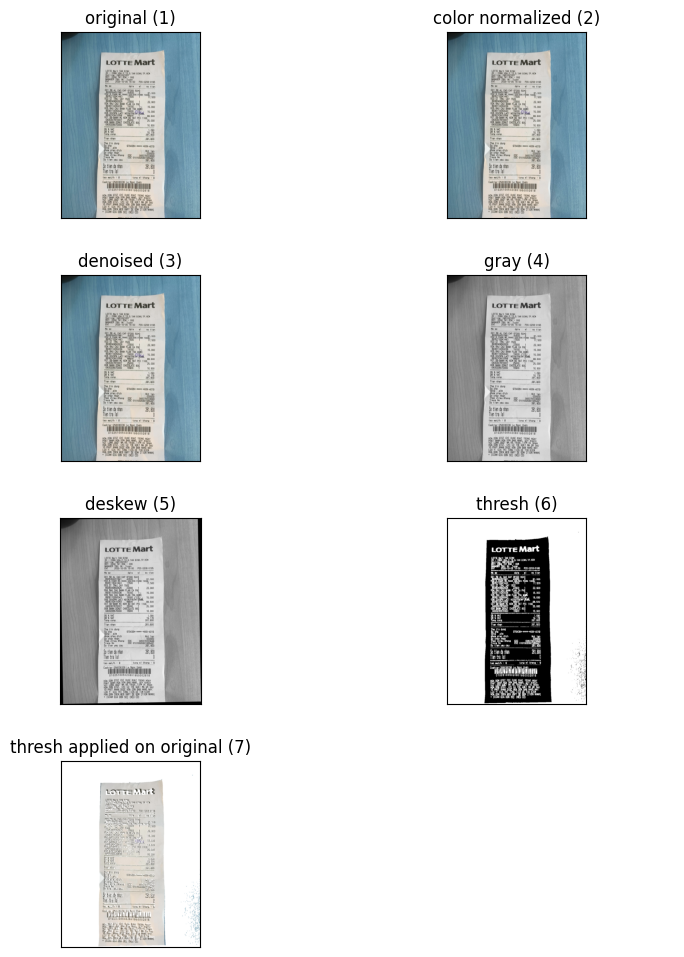

In [65]:
# run preprocessing
threshold_val= 175
img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh = preprocess_image(img_path, threshold_val)
plot_processing_images(img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh)

- let's take a closer look at the final product - the output of thresholding

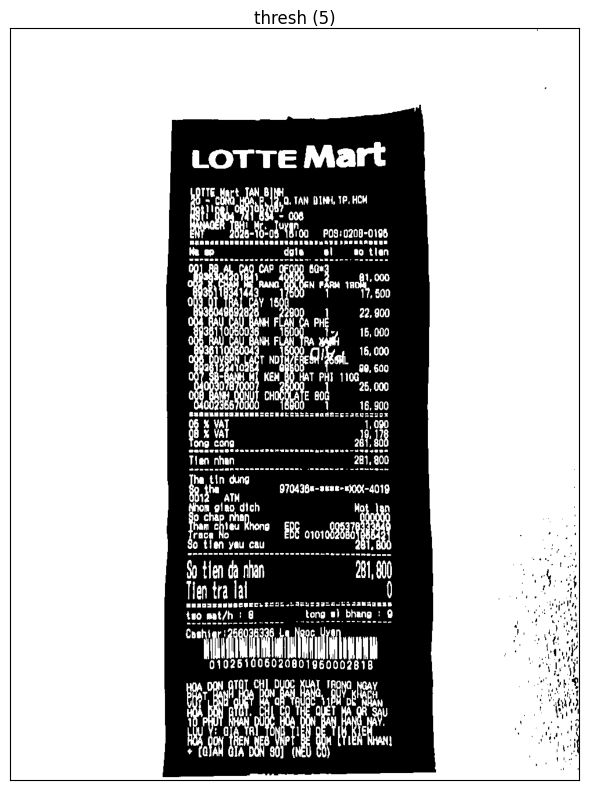

In [66]:
import matplotlib.pyplot as plt

fig, sub = plt.subplots(nrows=1, ncols=1, figsize=(8, 8));
sub.imshow(img_thresh, cmap='gray')
sub.set_xticks([]);
sub.set_yticks([]);
sub.set_title("thresh (5)", wrap=True, ha='center',va="top")
fig.tight_layout();

- the final processed image - output by step 5 binarization - is what we will feed into the ocr model next
- this drastically simplifies the image, making it much easier for ocr to work well
- to see the effect of `threshold_val` lets pick a few other values for this parameter, process with them, and plot the results
- some choices of this value are very helpful, others not so much

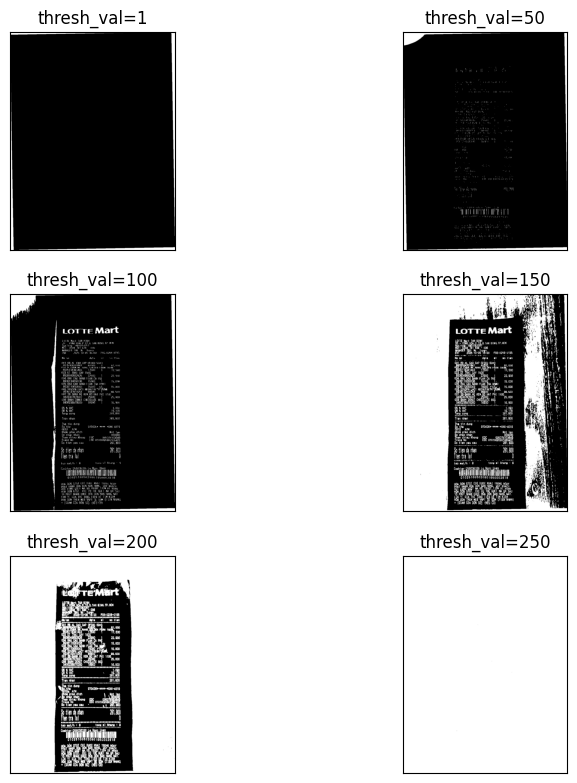

In [67]:
import matplotlib.pyplot as plt

threshold_test_imgs = []
test_threshold_vals = [1,50,100,150,200,250]
for threshold_val in test_threshold_vals:
    img_orig, img_norm, img_denoise, img_gray, img_deskew, img_thresh_test = preprocess_image(img_path, threshold_val)
    threshold_test_imgs.append(img_thresh_test)

fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(8, 8));
fig.tight_layout();

axarr[0,0].imshow(threshold_test_imgs[0], cmap='gray');
axarr[0,0].set_xticks([]);
axarr[0,0].set_yticks([]);
axarr[0,0].set_title(f"thresh_val={test_threshold_vals[0]}");

axarr[0,1].imshow(threshold_test_imgs[1], cmap='gray');
axarr[0,1].set_xticks([]);
axarr[0,1].set_yticks([]);
axarr[0,1].set_title(f"thresh_val={test_threshold_vals[1]}");

axarr[1,0].imshow(threshold_test_imgs[2], cmap='gray');
axarr[1,0].set_xticks([]);
axarr[1,0].set_yticks([]);
axarr[1,0].set_title(f"thresh_val={test_threshold_vals[2]}");

axarr[1,1].imshow(threshold_test_imgs[3], cmap='gray');
axarr[1,1].set_xticks([]);
axarr[1,1].set_yticks([]);
axarr[1,1].set_title(f"thresh_val={test_threshold_vals[3]}");

axarr[2,0].imshow(threshold_test_imgs[4], cmap='gray');
axarr[2,0].set_xticks([]);
axarr[2,0].set_yticks([]);
axarr[2,0].set_title(f"thresh_val={test_threshold_vals[4]}");

axarr[2,1].imshow(threshold_test_imgs[5], cmap='gray');
axarr[2,1].set_xticks([]);
axarr[2,1].set_yticks([]);
axarr[2,1].set_title(f"thresh_val={test_threshold_vals[5]}");

- what if your image has both dark and light text?
- binarize twice - once high threshold, one low

- with pre-processing complete we can now process our thresholded image through ocr
- here we use the popular [pytesseract](https://github.com/madmaze/pytesseract)
- we use a custom option:
    - [page segmentation mode (psm)](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/): tesseract allows a user to input different assumptions about where and how text is present in an input image.  we use the default selection 3 which makes broad assumption about the text in our input image(s) and attempts to adjust to whatever structure exists therein
- we process our original image and the thresholded versions for comparison
- text extracted from the heavily processed threshold image is much better

In [68]:
import pytesseract

# run ocr and clean up the result a bit
text_from_orig_img = pytesseract.image_to_string(img_orig, lang='eng',config="--psm 3")
text_from_orig_img = text_from_orig_img.replace("\n", " ").strip()
print(f'text imputed from original image --> "{text_from_orig_img}"')

text_from_thresh_img = pytesseract.image_to_string(img_thresh, lang='eng',config="--psm 3")
text_from_thresh_img = text_from_thresh_img.replace("\n", " ").strip()
print(f'text imputed from threshold image --> "{text_from_thresh_img}"')

text imputed from original image --> "LOTTE Mart  in hte TAN BINA, TP, HOM us op Ml 8: 0208-0105  IBN rh vl  22, 900 15, 000  The tin du ‘ te A 970436%-naxx- -4019  on Ah dich  etc ono gp ol  0 “fi en yeu cau"
text imputed from threshold image --> "LoTTe Mart  TT Mart, JAN B Ae VOC Gnd renters  ye  i) ey r on Cts)  MW) KEM 80 HAT Mi ae  ea iri A ee eT  ee Lee he CG ar i Bi i"


- notice: with our choice of parameters no text was detected on the original image
- lets process one more time and illustrate the detections in each case

In [70]:
import copy
from pytesseract import Output
import cv2

def process_and_plot_detections(img: np.ndarray) -> None:
    plot_img = copy.deepcopy(img)
    plot_img_template = copy.deepcopy(img)
    d = pytesseract.image_to_data(plot_img, config="--psm 3", output_type=Output.DICT)
    if len(plot_img.shape) < 3:
        plot_img_template = np.zeros(plot_img.shape + (3,))
        plot_img_template[:,:,0] = plot_img
        plot_img_template[:,:,1] = plot_img
        plot_img_template[:,:,2] = plot_img

    n_boxes = len(d['level'])
    for i in range(n_boxes):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        if w != plot_img_template.shape[1] and h != plot_img_template.shape[0]:
            text = d["text"][i]
            cv2.rectangle(plot_img_template, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(plot_img_template, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.75, (0, 0, 255), 3) # thank you --> https://pyimagesearch.com/2020/05/25/tesseract-ocr-text-localization-and-detection/
    plt.imshow(plot_img_template.astype('uint8'))
    plt.axis("off")


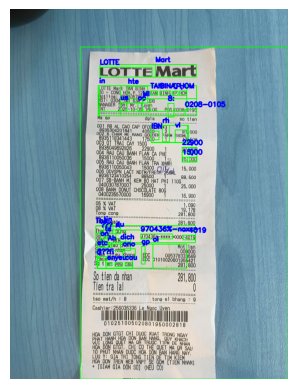

In [71]:
process_and_plot_detections(img_orig)

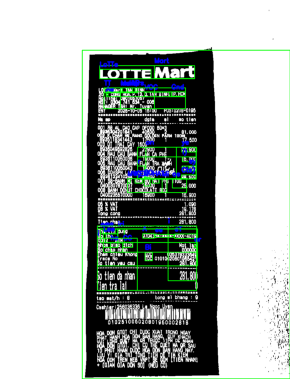

In [72]:
process_and_plot_detections(img_thresh)

- fire up the streamlit app (see this repo's `README.md`) locally to start playing around with this kind of stuff immediately